In [1]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import numpy as np
import IPython.display as ipd
from model.resnet import resnet152, resnet34, resnet18

from utils.dataloader import CaptchaDataset

C:\Users\J\anaconda3\envs\new_base\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# hyperparameter

In [2]:
EPOCHS = 50
CUDA = torch.cuda.is_available()
DEVICE = 'cuda' if CUDA else 'cpu'
MODEL_PATH = './weights/resnet18_resize'
BATCH_SIZE = 1
PATIENCE = 5

# dataloader

In [3]:
image_transform = transforms.Compose([
    # transforms.Resize([224, 224]),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225])
])

dataset = CaptchaDataset('./Large_Captcha_Dataset', isFilter=True, isCrop=True, isResize=True)
# dataset = CaptchaDataset('./Large_Captcha_Dataset', isFilter=True, isCrop=True)

In [4]:
random_seed = 123
test_split = 0.2
validation_split = 0.1
shuffling_dataset = True
dataset_size = len(dataset) # 82328

In [5]:
indices = list(range(dataset_size))
test_split_size = int(np.floor(test_split * dataset_size)) # 16465
validation_split_size = int(np.floor(test_split_size * 0.5)) # 8232

In [6]:
if shuffling_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, test_indices = indices[test_split_size:], indices[:test_split_size]
train_indices, val_indices = train_indices[validation_split_size:], train_indices[:validation_split_size]

In [7]:
train_sampler = SubsetRandomSampler(train_indices) # 57631
valid_sampler = SubsetRandomSampler(val_indices) # 8232
test_sampler = SubsetRandomSampler(test_indices) # 16465

In [8]:
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
val_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=valid_sampler)
test_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=test_sampler)

# model

In [9]:
model = resnet18()

In [10]:
if CUDA:
    model = model.cuda()

# train

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

In [12]:
loss_history = []
val_loss_history = []

In [13]:
model.train()
'done'

'done'

24/50, 1169.78 sec/epoch
stop cnt=4/5, current loss=0.0733, val loss=0.8055


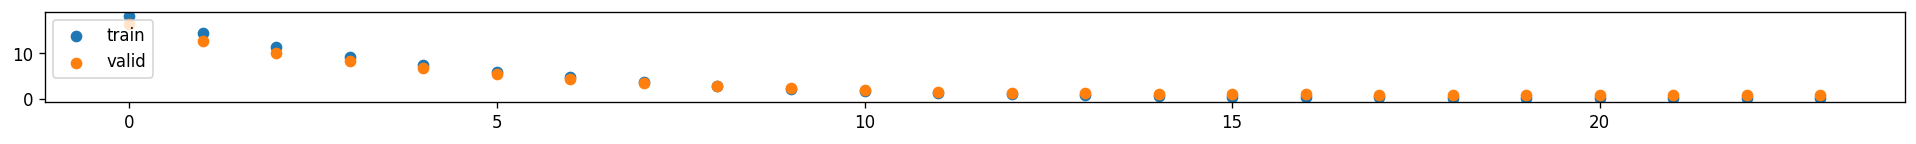

100%|██████████| 8232/8232 [00:46<00:00, 178.72it/s]


In [14]:
min_val_loss = 20.
stop_cnt = 0
for e in range(EPOCHS):
    start_time = time.time()
    current_loss = []
    current_val_loss = []
    
    for (x, y) in tqdm(train_dataloader):
        optimizer.zero_grad()
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        y1, y2, y3, y4, y5 = y[:, 0], y[:, 1], y[:, 2], y[:, 3], y[:, 4]
        
        pred1, pred2, pred3, pred4, pred5 = model(x)

        loss1 = criterion(pred1, y1)
        loss2 = criterion(pred2, y2)
        loss3 = criterion(pred3, y3)
        loss4 = criterion(pred4, y4)
        loss5 = criterion(pred5, y5)
        loss = loss1 + loss2 + loss3 + loss4 + loss5
        current_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
    current_loss = np.mean(current_loss).item()
    loss_history.append(current_loss)
    
    for (x, y) in tqdm(val_dataloader):
        with torch.no_grad():
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            
            y1, y2, y3, y4, y5 = y[:, 0], y[:, 1], y[:, 2], y[:, 3], y[:, 4]
            
            pred1, pred2, pred3, pred4, pred5 = model(x)
            
            loss1 = criterion(pred1, y1)
            loss2 = criterion(pred2, y2)
            loss3 = criterion(pred3, y3)
            loss4 = criterion(pred4, y4)
            loss5 = criterion(pred5, y5)
            loss = loss1 + loss2 + loss3 + loss4 + loss5
            current_val_loss.append(loss.item())

    current_val_loss = np.mean(current_val_loss).item()
    val_loss_history.append(current_val_loss)
    
    if current_val_loss < min_val_loss:
        min_val_loss = current_val_loss
        stop_cnt = 0
        torch.save(model.state_dict(), MODEL_PATH)
        
    stop_cnt += 1
    if stop_cnt == PATIENCE:
        break
    
    ipd.clear_output(wait=True)
    print(f"{e+1}/{EPOCHS}, {time.time()-start_time:.2f} sec/epoch")
    print(f"stop cnt={stop_cnt}/{PATIENCE}, current loss={current_loss:.4f}, val loss={current_val_loss:.4f}")
    plt.figure(figsize=(20,1),dpi=120)
    plt.scatter(np.arange(len(loss_history)), loss_history, label='train')
    plt.scatter(np.arange(len(val_loss_history)), val_loss_history, label='valid')
    plt.legend(loc=2)
    plt.show()
    

25/50, 1211.14 sec/epoch
stop cnt=5/5, current loss=0.0663, val loss=0.8989


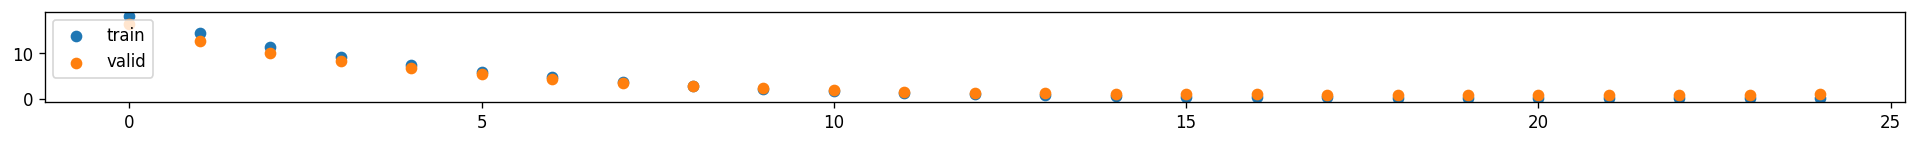

In [15]:
print(f"{e+1}/{EPOCHS}, {time.time()-start_time:.2f} sec/epoch")
print(f"stop cnt={stop_cnt}/{PATIENCE}, current loss={current_loss:.4f}, val loss={current_val_loss:.4f}")
plt.figure(figsize=(20,1),dpi=120)
plt.scatter(np.arange(len(loss_history)), loss_history, label='train')
plt.scatter(np.arange(len(val_loss_history)), val_loss_history, label='valid')
plt.legend(loc=2)
plt.show()

# test

In [16]:
model.eval()
model.load_state_dict(torch.load(MODEL_PATH))
'done'

'done'

In [17]:
pred_list = [[] for i in range(5)]
true_list = [[] for i in range(5)]

for (x, y) in tqdm(test_dataloader):
    with torch.no_grad():
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        y1, y2, y3, y4, y5 = y[:, 0], y[:, 1], y[:, 2], y[:, 3], y[:, 4]

        pred1, pred2, pred3, pred4, pred5 = model(x)
        pred1 = torch.argmax(pred1, -1)
        pred2 = torch.argmax(pred2, -1)
        pred3 = torch.argmax(pred3, -1)
        pred4 = torch.argmax(pred4, -1)
        pred5 = torch.argmax(pred5, -1)
        
        pred_list[0] += pred1.detach().cpu().tolist()
        pred_list[1] += pred2.detach().cpu().tolist()
        pred_list[2] += pred3.detach().cpu().tolist()
        pred_list[3] += pred4.detach().cpu().tolist()
        pred_list[4] += pred5.detach().cpu().tolist()
        
        true_list[0] += y1.detach().cpu().tolist()
        true_list[1] += y2.detach().cpu().tolist()
        true_list[2] += y3.detach().cpu().tolist()
        true_list[3] += y4.detach().cpu().tolist()
        true_list[4] += y5.detach().cpu().tolist()
        
        # print(pred_list)
        
        # for idx in range(BATCH_SIZE):
        #     plt.imshow(x[idx].detach().cpu().permute(1, 2, 0))
        #     print(keys[y1[idx]], keys[y2[idx]], keys[y3[idx]], keys[y4[idx]], keys[y5[idx]])
        #     print(keys[pred1[idx]], keys[pred2[idx]], keys[pred3[idx]], keys[pred4[idx]], keys[pred5[idx]])
        #     break
        # break

100%|██████████| 16465/16465 [01:23<00:00, 196.40it/s]


In [18]:
pred_list = np.array(pred_list)
true_list = np.array(true_list)

In [19]:
(pred_list==true_list).shape

(5, 16465)

In [24]:
np.sum(pred_list==true_list, axis=1)/16465

array([0.88017006, 0.7792894 , 0.73877923, 0.74667476, 0.86292135])

In [25]:
np.average(np.sum(pred_list==true_list, axis=1))/16465

0.8015669602186456

# visalization

In [22]:
keys = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"

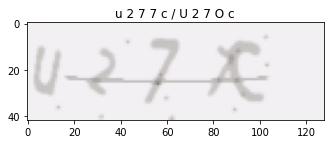

In [23]:
for (x, y) in test_dataloader:
    with torch.no_grad():
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        y1, y2, y3, y4, y5 = y[:, 0], y[:, 1], y[:, 2], y[:, 3], y[:, 4]

        pred1, pred2, pred3, pred4, pred5 = model(x)
        pred1 = torch.argmax(pred1, -1)
        pred2 = torch.argmax(pred2, -1)
        pred3 = torch.argmax(pred3, -1)
        pred4 = torch.argmax(pred4, -1)
        pred5 = torch.argmax(pred5, -1)
        
        y1 = list(map(lambda x: keys[x], y1))
        y2 = list(map(lambda x: keys[x], y2))
        y3 = list(map(lambda x: keys[x], y3))
        y4 = list(map(lambda x: keys[x], y4))
        y5 = list(map(lambda x: keys[x], y5))
        
        pred1 = list(map(lambda x: keys[x], pred1))
        pred2 = list(map(lambda x: keys[x], pred2))
        pred3 = list(map(lambda x: keys[x], pred3))
        pred4 = list(map(lambda x: keys[x], pred4))
        pred5 = list(map(lambda x: keys[x], pred5))
        
        
        for idx in range(BATCH_SIZE):
            true_str = f'{y1[idx]} {y2[idx]} {y3[idx]} {y4[idx]} {y5[idx]}'
            pred_str = f'{pred1[idx]} {pred2[idx]} {pred3[idx]} {pred4[idx]} {pred5[idx]}'
            plt.figure(figsize=(50,50))
            plt.subplot(8, 8, idx+1)
            plt.title(f'{true_str} / {pred_str}')
            plt.imshow(x[idx].detach().cpu().permute(1, 2, 0))
        break